# **Predicting Water Pump Functionality in Tanzania : Machine Learning Approach to Enhance Resource Allocation**


### **Business Understanding**

### Overview

Tanzania is in the midst of a crisis, out of its 65 million population, 55%  and 11% of rural and urban population respectively, do not have access to clean water. People living under these circumstances, particularly women and girls, spend a significant amount of time traveling long distances to collect water.This poses significant risks in public health, economic productivity and educational opportunities.Now more than everaccess to safe water at home is critical to families in Tanzania.

####      Problem Statement

Access to clean and functional water points is vital for rural and urban communities in Tanzania. However, many wells in Tanzania are either non-functional or require repairs, affecting water accessibility and community well-being.

The central question is: **How can we predict the functionality of water points to prioritize maintenance and improve resource allocation?**

####    Key Stakeholders

Tanzanian Government Agencies, NGOs, Community Leaders, Technical Team (Engineers and Technicians)



### Business goals

- **Optimize resource allocation :** Predict well functionality to prioritize repairs for non-functional and poorly functioning wells . 

- **Improve community access to clean water :** Reduce repairs downtime and increase availability of functional water points

- **Support sustainability and durability of wells :** Provide insights to future installations and maintenance strategies. What factors contribute to well failures?

### **Proposed Solution (Metric : Accuracy Score >= 80%)**

Develop a machine learning model to accurately predict the functionality status of water wells (functional, non-functional, functional needs repair) based on available data.
 
This model will enable repair prioritization, informed decision making (data-driven), and improvement of water access

####    Objectives
-  Develop a Predictive Model: Create a machine learning model that accurately predicts the functionality status of water wells using features like pump type, region and other relevant factors.

-  Identify Key Predictors: Analyze the model to identify the key factors that contribute to well functionality or failure, providing insights that can inform future well design and maintenance strategies.

### **Data Understanding**

The dataset provided on https://www.drivendata.org/ by **Taarifa** and the **Tanzanian Ministry of Water**. More details on the competition could be found [here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/).
Feature description for the data can be found in [data description](data_description.txt).
##### **Data assumptions :**
- The dataset is representative of all wells in Tanzania
- Historical data trends will hold for future predictions

### **Methodology**

### **Import Libraries**

In [34]:
import pandas as pd
import numpy as np
import sys
import os

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Machine learning
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Feature selection and engineering
from sklearn.feature_selection import RFE

#Model evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Add the parent directory of 'modules' to sys.path
sys.path.append(os.path.abspath("../modules"))

# Now import
from modules.EDA import EDA
from modules.dataprocessor import DataProcessor
from modules.testprocessor import TestDatasetProcessor

### **Load Dataset**

In [35]:
# Load the dataset
df = pd.read_csv("./data/wells_data_cleaned.csv")
# Check the first few rows to confirm the structure
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region,...,construction_year,extraction_type_class,management_group,payment_type,quality_group,quantity,source_class,waterpoint_type,status_group,year_recorded
0,69572,6000.0,2011-03-14,ROMAN,1390.0,ROMAN,34.938093,-9.856322,LAKE NYASA,IRINGA,...,1999,GRAVITY,USER-GROUP,ANNUALLY,GOOD,ENOUGH,GROUNDWATER,COMMUNAL STANDPIPE,FUNCTIONAL,2011
1,8776,0.0,2013-03-06,GRUMETI,1399.0,GRUMETI,34.698766,-2.147466,LAKE VICTORIA,MARA,...,2010,GRAVITY,USER-GROUP,NEVER PAY,GOOD,INSUFFICIENT,SURFACE,COMMUNAL STANDPIPE,FUNCTIONAL,2013
2,34310,25.0,2013-02-25,LOTTERY CLUB,686.0,WORLD VISION,37.460664,-3.821329,PANGANI,MANYARA,...,2009,GRAVITY,USER-GROUP,PER BUCKET,GOOD,ENOUGH,SURFACE,COMMUNAL STANDPIPE MULTIPLE,FUNCTIONAL,2013
3,67743,0.0,2013-01-28,UNICEF,263.0,UNICEF,38.486161,-11.155298,RUVUMA / SOUTHERN COAST,MTWARA,...,1986,SUBMERSIBLE,USER-GROUP,NEVER PAY,GOOD,DRY,GROUNDWATER,COMMUNAL STANDPIPE MULTIPLE,NON FUNCTIONAL,2013
4,19728,0.0,2011-07-13,ACTION IN A,0.0,ARTISAN,31.130847,-1.825359,LAKE VICTORIA,KAGERA,...,0,GRAVITY,OTHER,NEVER PAY,GOOD,SEASONAL,SURFACE,COMMUNAL STANDPIPE,FUNCTIONAL,2011


In [72]:
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'basin', 'region', 'lga',
       'population', 'public_meeting', 'scheme_management', 'permit',
       'construction_year', 'extraction_type_class', 'management_group',
       'payment_type', 'quality_group', 'quantity', 'source_class',
       'waterpoint_type', 'status_group', 'year_recorded'],
      dtype='object')

### **Exploratory Data Analysis**

- Data cleaning has been conducted in [data preparation](./notebooks/1.0%20Data%20Preparation.ipynb).
- Initial exploratory analysis has been done in this [file](./notebooks/2.0%20EDA.ipynb). We will have a more summarised form of EDA in this `index.ipynb` file.


In [49]:
# Summary of the target value
df.status_group.value_counts(normalize=True)

FUNCTIONAL                 0.543081
NON FUNCTIONAL             0.384242
FUNCTIONAL NEEDS REPAIR    0.072677
Name: status_group, dtype: float64

- Class imbalances observed with 54% of dataset being Functional wells, while Functional needs repair only has 7% of data

In [81]:
# Function to plot a stacked bar graph
def plot_stackedbar(table, title, figsize):
    """
    Parameters:
    - table: Crosstab DataFrame (e.g., from pd.crosstab)
    - title: Title of the plot
    - figsize: Tuple specifying the figure size
    """
    # colors
    water_cmap = LinearSegmentedColormap.from_list("water_theme", ["#00FFFF", "#008080", "#00008B"])
    # plot
    table.plot(kind="barh", stacked=True, figsize=figsize, colormap=water_cmap, alpha=0.8)
    plt.title(title, loc="left",fontsize=20, pad=40)
    plt.xticks(rotation=45)
    plt.legend(title="Well Status", fontsize=14, loc='upper left', 
        bbox_to_anchor=([0.38, 1.1, 0.58, 0]), 
        ncol=len(table.columns),frameon=True)
    plt.tight_layout()
plt.show()

- A look at visualization between categorical column and the target group (status_group)

 ` Well functionality status by region`

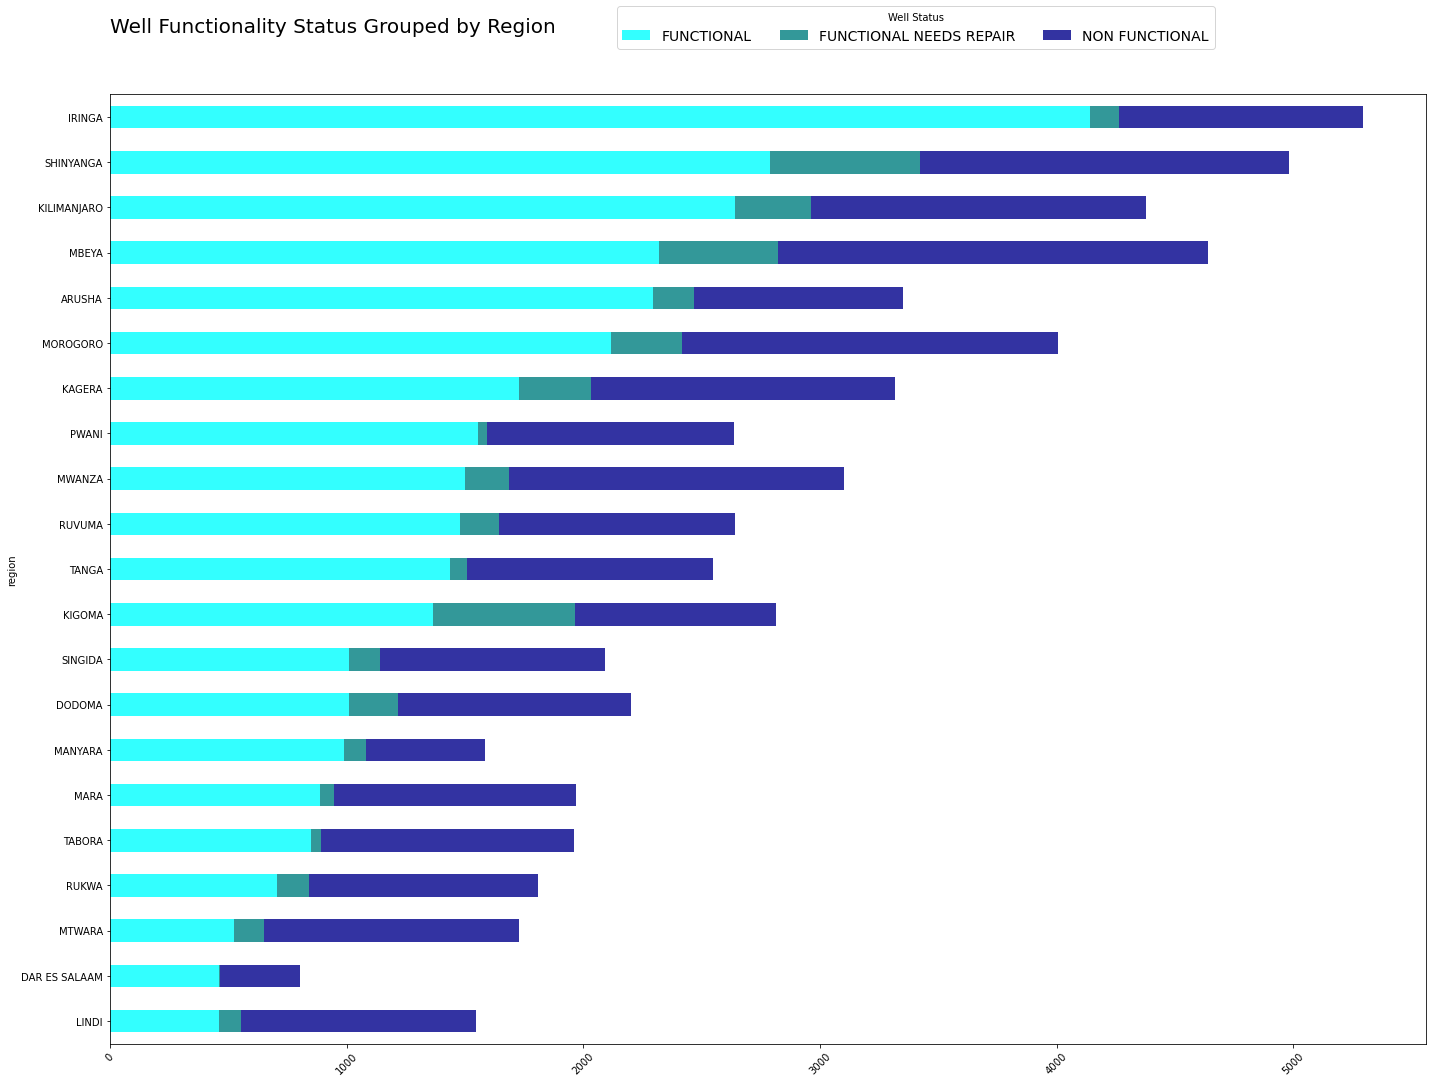

In [82]:
table = pd.crosstab(df['region'], df['status_group']).sort_values(by='FUNCTIONAL')
title = 'Well Functionality Status Grouped by Region\n'
plot_stackedbar(table, title, (20,15))

- **Iringa** has the most number of wells and functional wells proportion as well.
- **Dar es Salaam** has the least no of wells
- **Lindi** has more wells than **Dar es Salaam**, but yet a very high portion of them are `non functional`.

 ` Well functionality status by basin`

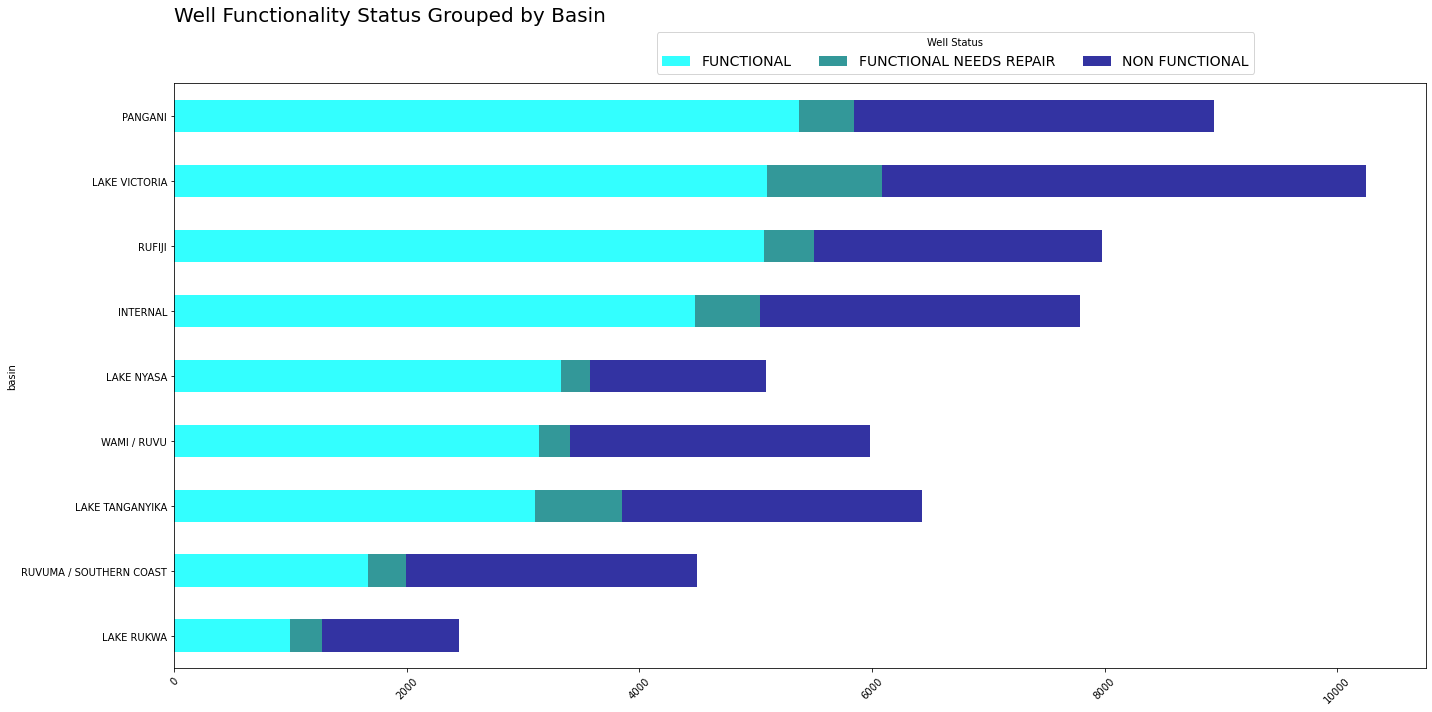

In [95]:
table = pd.crosstab(df['basin'], df['status_group']).sort_values(by='FUNCTIONAL')
title = 'Well Functionality Status Grouped by Basin\n'
plot_stackedbar(table, title, (20,10))

- Ruvuma/Southern coast seems to have the basin with the highest number of non-functional wells in comparison to its population

` Well functionality status by Quantity`

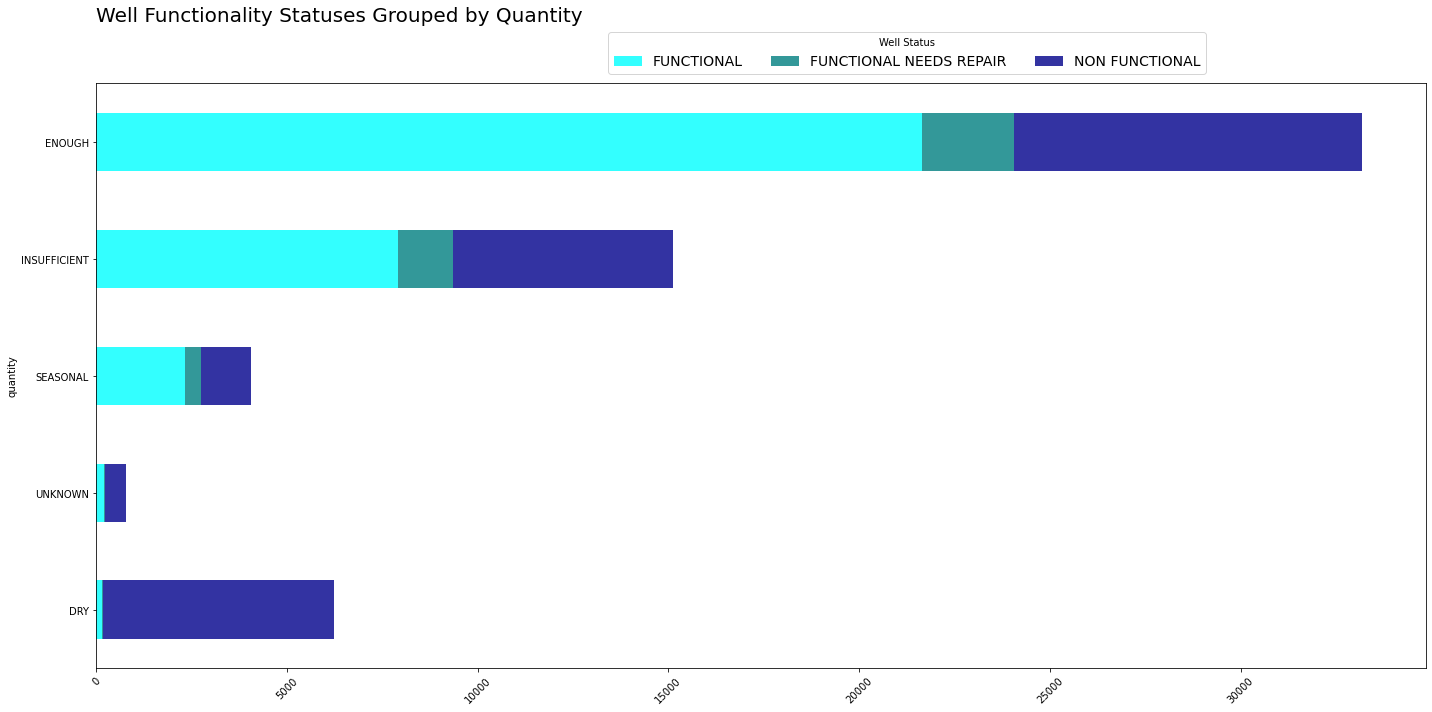

In [92]:
table = pd.crosstab(df['quantity'], df['status_group']).sort_values(by='FUNCTIONAL')
title = 'Well Functionality Statuses Grouped by Quantity\n'
plot_stackedbar(table, title, (20,10))

- **Dry** wells are oftenly *non-functional* as observed.
- **Unknown group**, has more *non-functional* well than the overall population. Since unknown lacks some data, this may indicate poor management and that the well may not well be taken care of

` Well functionality status by waterquality`

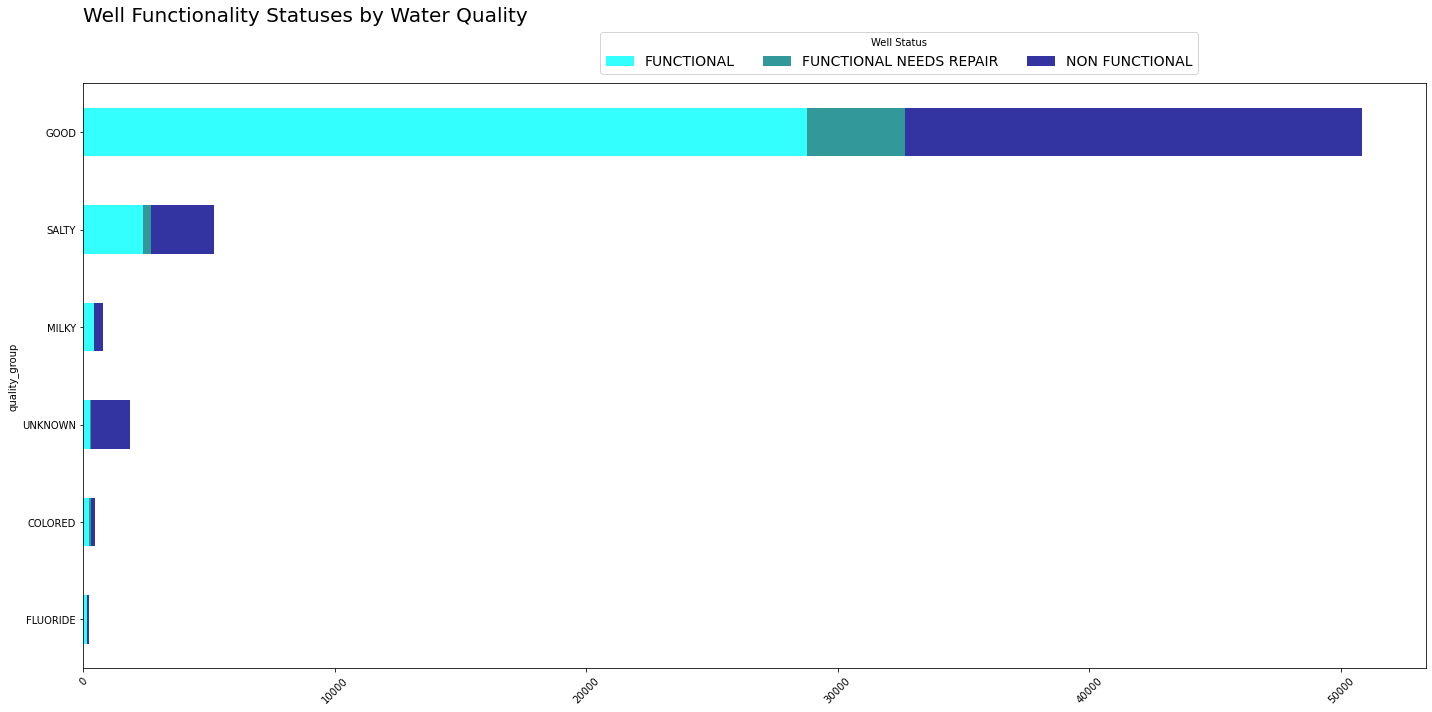

In [93]:
table = pd.crosstab(df['quality_group'], df['status_group']).sort_values(by='FUNCTIONAL')
title = 'Well Functionality Statuses by Water Quality\n'
plot_stackedbar(table, title, (20,10))

- In terms of quality, unknown group still has the highest percentage of non-functional wells in comparison to its population

` Well functionality status by extraction type`

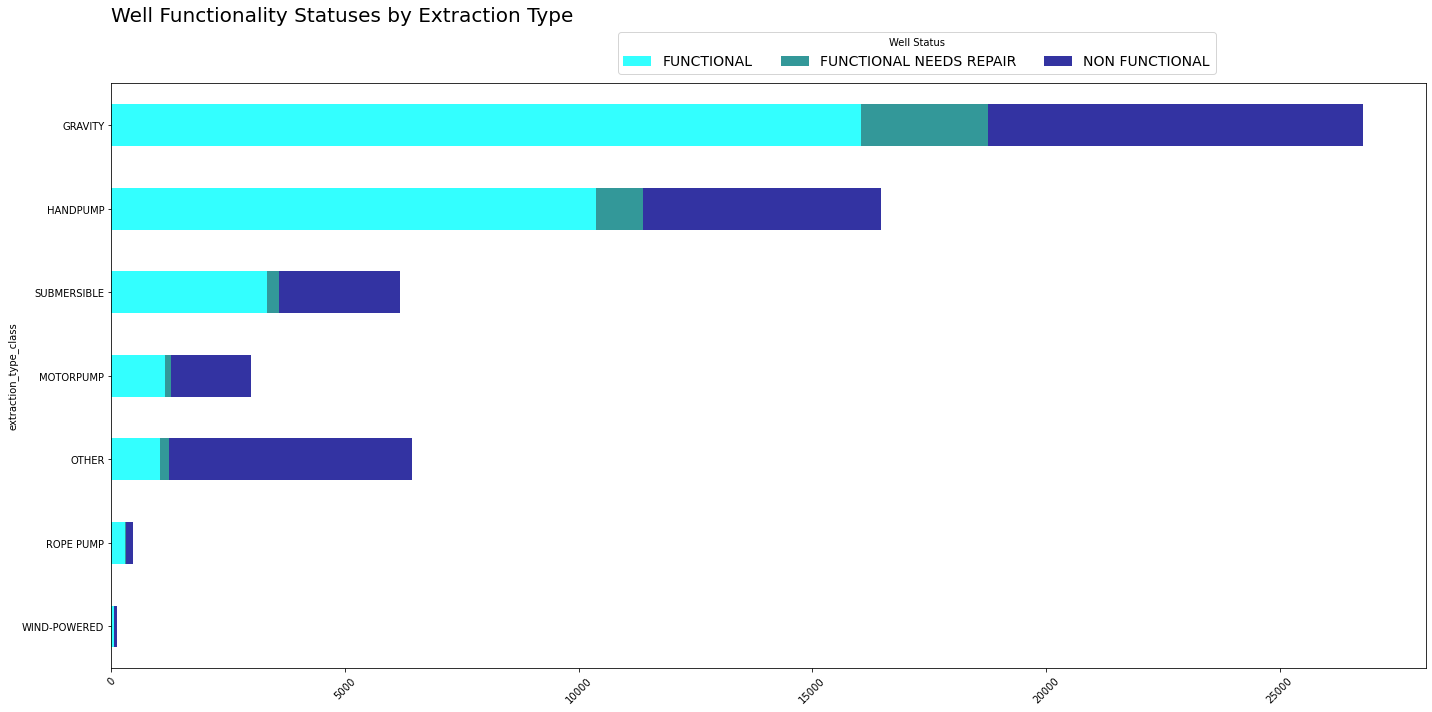

In [97]:
table = pd.crosstab(df['extraction_type_class'], df['status_group']).sort_values(by='FUNCTIONAL')
title = 'Well Functionality Statuses by Extraction Type\n'
plot_stackedbar(table, title, (20,10))

` Well functionality status by waterpoint_type`

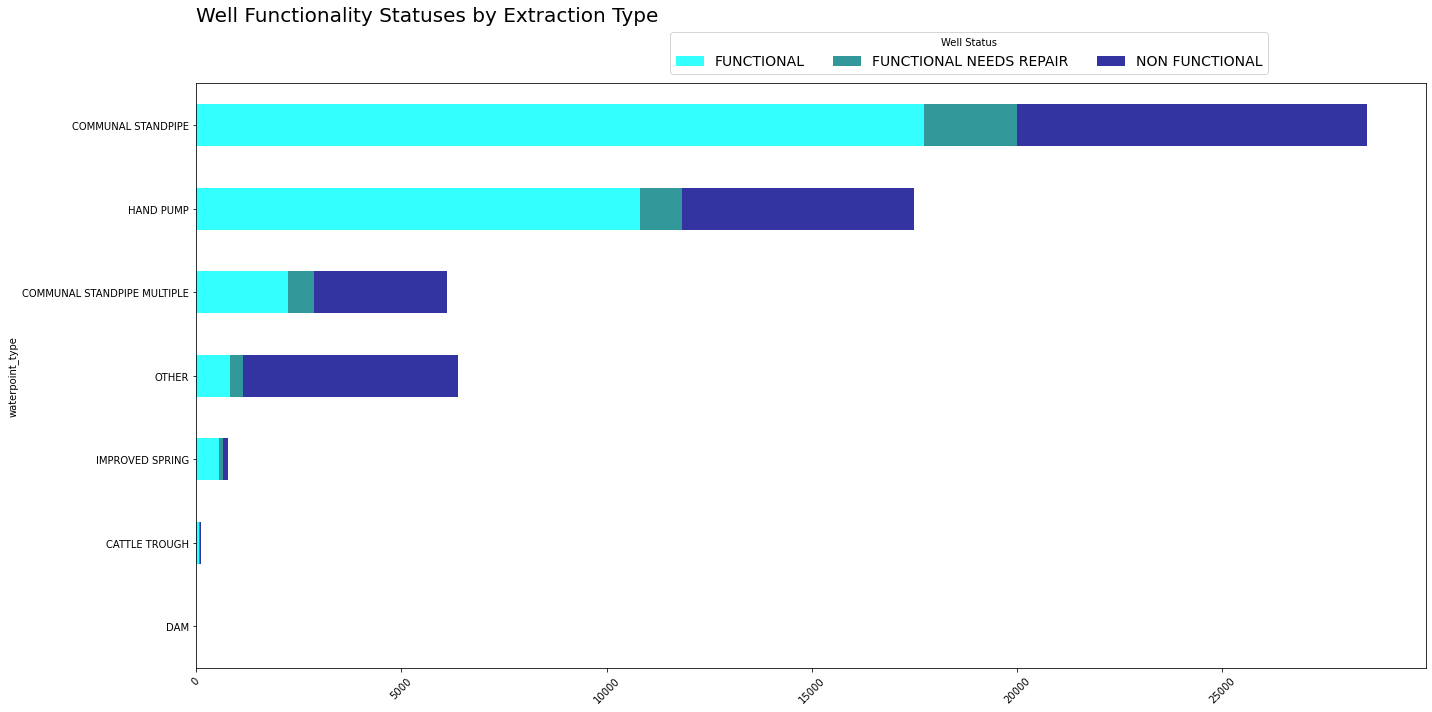

In [98]:
table = pd.crosstab(df['waterpoint_type'], df['status_group']).sort_values(by='FUNCTIONAL')
title = 'Well Functionality Statuses by Extraction Type\n'
plot_stackedbar(table, title, (20,10))

` Well functionality status by source_class`

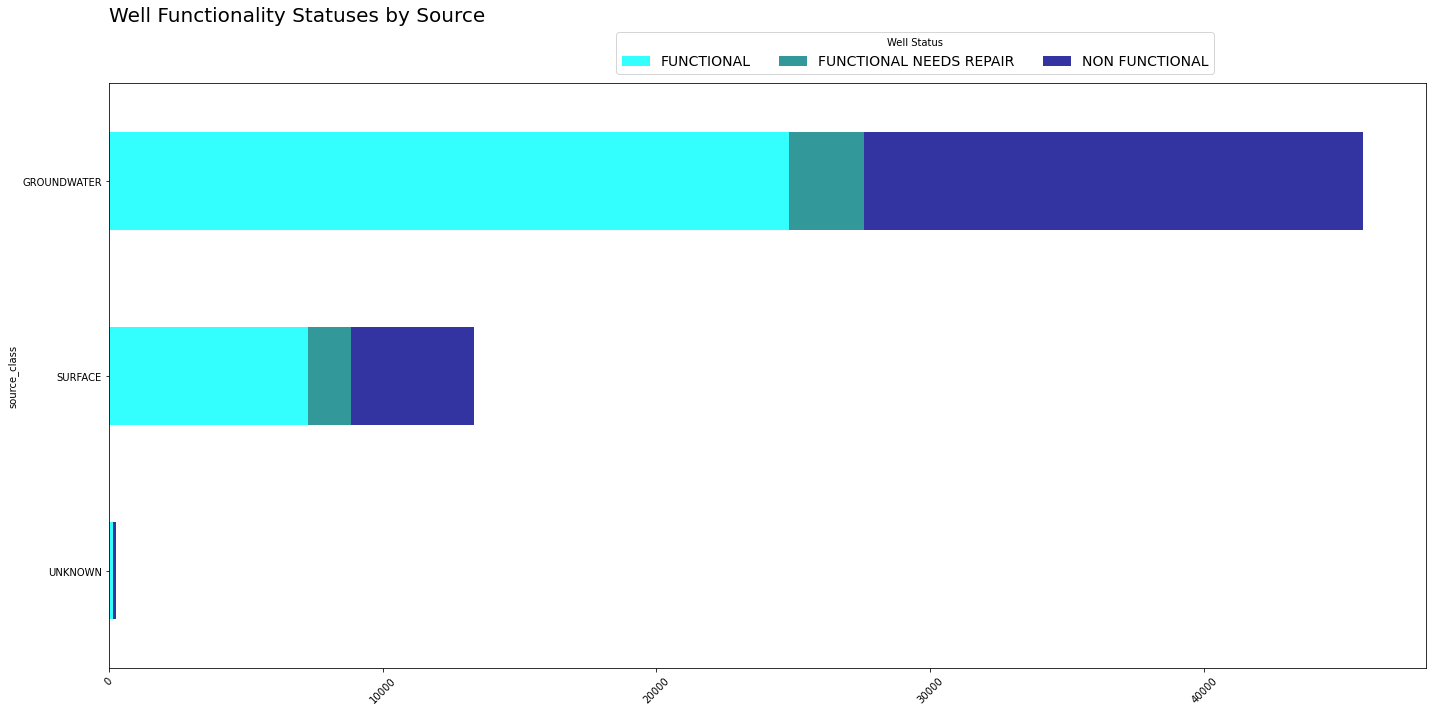

In [99]:
table = pd.crosstab(df['source_class'], df['status_group']).sort_values(by='FUNCTIONAL')
title = 'Well Functionality Statuses by Source\n'
plot_stackedbar(table, title, (20,10))

` Well functionality status by payment`

In [101]:
payment_table = pd.crosstab(df['payment_type'], df['status_group'], normalize='index')\
                        .sort_values(by='FUNCTIONAL', ascending=False)
payment_table

status_group,FUNCTIONAL,FUNCTIONAL NEEDS REPAIR,NON FUNCTIONAL
payment_type,,,
ANNUALLY,0.752334,0.067820,0.179846
PER BUCKET,0.677796,0.045520,0.276683
MONTHLY,0.660482,0.111687,0.227831
ON FAILURE,0.620593,0.070772,0.308636
OTHER,0.579696,0.111954,0.308349
NEVER PAY,0.448911,0.075233,0.475856
UNKNOWN,0.432512,0.052961,0.514527


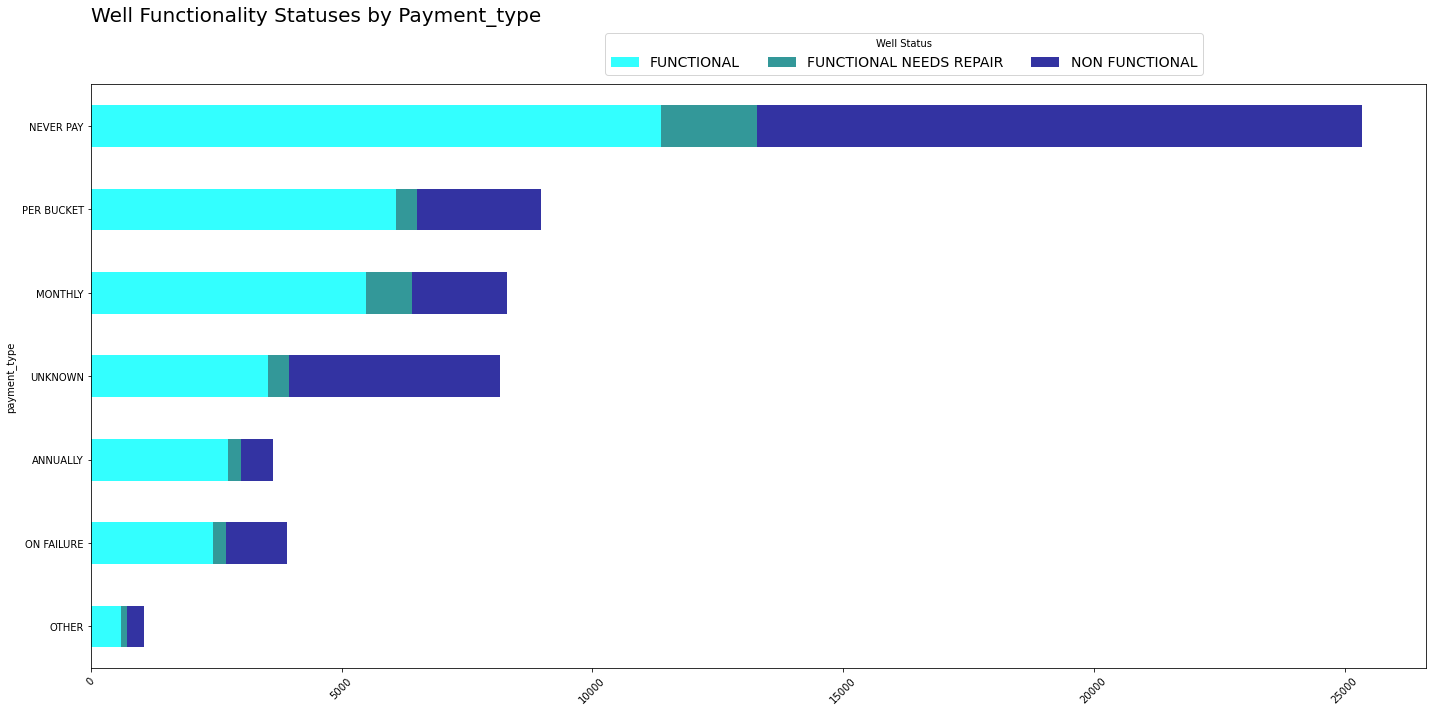

In [100]:
table = pd.crosstab(df['payment_type'], df['status_group']).sort_values(by='FUNCTIONAL')
title = 'Well Functionality Statuses by Payment_type\n'
plot_stackedbar(table, title, (20,10))


- Unknown category has the highest no of non-functional wells

### **Binary Classification**

The dataset is a case of **ternary classification**. I will recategorize the `NON FUNCTIONAL` and `FUNCTIONAL NEEDS REPAIR` in order to perform **binary classification**.This will help with to balance out the rare class `FUNCTIONAL NEEDS REPAIR`which was observed to be underperforming in the ternary classifier as shown in our [ternary model](./notebooks/3.0%20Ternary%20Modelling.ipynb).

In [102]:
# create a copy of our dataset to use for modelling
df_binary = df.copy()

#### Recatecorize Target Variable to Binary class
- Functional -> 0 , Non-functional -> 1 , Functional Needs Repair ->1

In [104]:
# Function to recategorize variables
def recategorize_target_variable(df, target_column, new_column):
   
    df[new_column] = df[target_column].apply(lambda x: 0 if x == 'FUNCTIONAL' else 1)
    return df

In [108]:
# recategorizing class using our function
df_binary = recategorize_target_variable(df_binary, target_column='status_group', new_column='status_group_binary')
print("Binary Target Variable Distribution:")
print(df_binary['status_group_binary'].value_counts())

Binary Target Variable Distribution:
0    32259
1    27141
Name: status_group_binary, dtype: int64


In [109]:
# Creating a new dataframe to be used in binary classification
df1 = df_binary.drop('status_group',axis = 1)
df1.to_csv ('./data/df_binary.csv',index = False)

#### **Data Processing**